## Light 2 Numerical and Data Analysis Answers

In [1]:
import numpy as np
import scipy.interpolate as interpolate
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import requests

## 1. Identify Balmer lines

*Author: Kate Storey-Fisher*

Download an optical spectrum of a star forming galaxy. Identify all Balmer emission lines that are apparent in the spectrum. Zooming in on Hα or Hβ, visually compare the Balmer absorption (in the stellar continuum) to the emission.

### Data ###

This is an optical spectrum of a galaxy in SDSS. The data and more info can be found here: https://dr12.sdss.org/spectrumDetail?mjd=53794&fiber=6&plateid=2214

In [2]:
request_template = 'https://dr13.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberid}'
request = request_template.format(plate=2214, fiberid=6, mjd=53794)
r = requests.get(request)
fp = open('spec-2214-53794-0006.fits', 'wb')
fp.write(r.content)
fp.close()

In [3]:
hdu = fits.open('spec-2214-53794-0006.fits')

In [4]:
header = hdu[0].header
data = hdu[1].data
z = 0.0657799 #Redshift at link above

In [5]:
wl = 10**data['loglam']
flux = data['flux']
model = data['model']

### Balmer Series

The Balmer series are lines due to transitions to the n=2 level of hydrogen. The wavelengths of the first few lines are given below.

The next line, H_epsilon, is outside of the region of our spectrum.

In [6]:
#Balmer series
halpha = 6564.5377
hbeta = 4861.3615
hgamma = 4340.462
hdelta = 4101.74
lines = [halpha, hbeta, hgamma, hdelta]
labels = [r'H$_{\alpha}$', r'H$_{\beta}$', r'H$_{\gamma}$', r'H$_{\delta}$']

Find the wavelength at which the lines are observed, due to redshifting.

In [7]:
#Shifted
lines_shifted = np.empty(len(lines))
for i in range(len(lines)):
    lines_shifted[i] = lines[i]*(1+z)

The H$\alpha$ line is clear, but the others are hard to see when looking at the full spectrum.

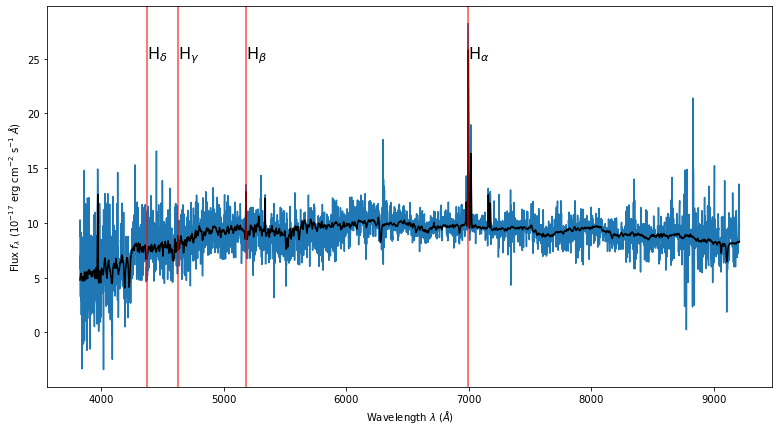

In [8]:
fig = plt.figure(figsize=(13, 7))
plt.plot(wl, flux)
plt.plot(wl, model, color='black')        
plt.xlabel('Wavelength $\lambda$ ($\AA$)')
plt.ylabel('Flux $f_\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA$)')

for line, label in zip(lines_shifted, labels):
    plt.axvline(line, color='red', alpha=0.7)
    plt.annotate(label, xy=(line, 25), xytext=(line, 25), size=16)

### Zooming in

We see that the H$\alpha$ line is very strong, and the H$\beta$ line also has a clear emission peak.
H$\gamma$ and H$\delta$ do not appear to have emission that is significant relative to the noise. The black 
lines in these plots are the model fit by the spectroscopic pipeline in SDSS, so it does not necessarily
faithfully represent the true galaxy spectrum.

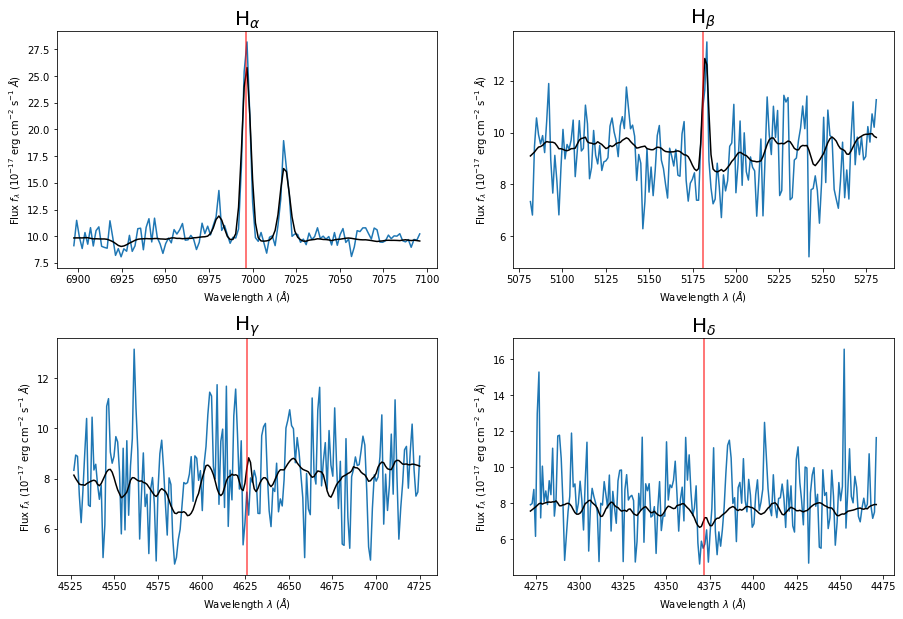

In [9]:
# Zooms
width = 100
fig, axarr = plt.subplots(2,2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)
count = 0
for i in range(2):
    for j in range(2):
        line = lines_shifted[count]
        wf = [(w, f, m) for w, f, m in zip(wl, flux, model) if (w<line+width) and (w>line-width)]
        wlcut = [tup[0] for tup in wf]
        fluxcut = [tup[1] for tup in wf]
        modelcut = [tup[2] for tup in wf]

        axarr[i,j].set_title(labels[count], size=20)
        axarr[i,j].plot(wlcut, fluxcut)
        axarr[i,j].plot(wlcut, modelcut, color='black')
        axarr[i,j].axvline(line, color='red', alpha=0.7)
        axarr[i,j].set_xlabel('Wavelength $\lambda$ ($\AA$)')
        axarr[i,j].set_ylabel('Flux $f_\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA$)')

        count += 1

### Absorption to Emission

Zooming in further on the H$\beta$ line to visually inspect it, the model (black) has clear emission and clear absorption. The absorption is in the underlying stellar continuum spectrum and reflects the presence of neutral, but excited, hydrogen gas in the stellar atmospheres. The absorption feature is believable in the data itself (blue), but it is less obviously real, because of the noise. 

Text(0, 0.5, 'Flux $f_\\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\\AA$)')

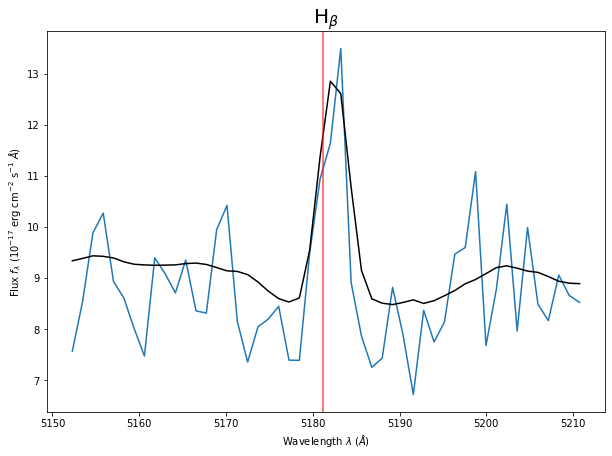

In [10]:
width = 30
fig = plt.figure(figsize=(10, 7))
count = 1
line = lines_shifted[count] #H_beta
wf = [(w, f, m) for w, f, m in zip(wl, flux, model) if (w<line+width) and (w>line-width)]
wlcut = [tup[0] for tup in wf]
fluxcut = [tup[1] for tup in wf]
modelcut = [tup[2] for tup in wf]

plt.title(labels[count], size=20)
plt.plot(wlcut, fluxcut)
plt.plot(wlcut, modelcut, color='black')
plt.axvline(line, color='red', alpha=0.7)
plt.xlabel('Wavelength $\lambda$ ($\AA$)')
plt.ylabel('Flux $f_\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA$)')

## 6. Estimate dust extinction

*Author: Jiarong Zhu*

Find the SDSS optical spectra and images for the two galaxies
UGC 10227 (a typical-looking disk galaxy observed at high inclination)
and MCG -01-53-020 (a typical-looking disk galaxy observed at low
inclination). A major difference in observing galaxies at these
inclinations is the resulting amount of dust extinction. For a
standard reddening law, how much extinction do you need to explain
the first galaxy spectrum as a reddened version of the second?

First we open the appropriate spectra, which can be found using the search facilities on SkyServer. Using the plate, MJD, and fiber numbers there, we construct the URL to download the data:

In [11]:
UG = fits.open('https://dr16.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/1056/spec-1056-52764-0308.fits')
MCG = fits.open('https://dr16.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/0637/spec-0637-52174-0403.fits')

Let's construct arrays with the rest-frame wavelength and the flux. We will not concern ourselves with the overall normalization of the flux in this step.

In [12]:
z_UG = UG[2].data['Z'][0]
z_MCG = MCG[2].data['Z'][0]
lam_UG = UG[1].data['loglam'] - np.log10(1. + z_UG)
lam_MCG = MCG[1].data['loglam'] - np.log10(1. + z_MCG)
f_UG = UG[1].data['flux']
f_MCG = MCG[1].data['flux']

We can plot both, and we see that for UGC 10227, which is seen edge-on, it is a much redder spectrum than MCG -01-53-020, which is seen face-on. But many of the small scale features of the spectra are similar: the 4000 Angstrom break, with its Calcium H and K lines, the G band features redward of 4000 Angstromes, Na D line, and the TiO bands. Not all the features are quite the same. MCG -01-53-020 has a weaker Mg b line and does not have evident H$\alpha$ emission. 

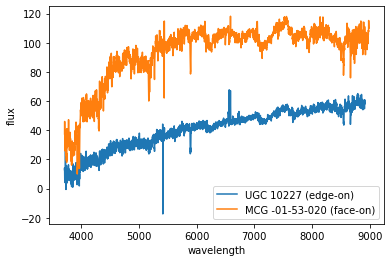

In [13]:
plt.figure()
plt.plot(10.**lam_UG, f_UG, label='UGC 10227 (edge-on)')
plt.plot(10.**lam_MCG, f_MCG, label='MCG -01-53-020 (face-on)')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

We want to put these functions on the same wavelength grid. For our purposes, a simple 3rd-order spline interpolation scheme will be sufficient. Note that for more demanding purposes, a more accurate interpolation, or avoiding interpolation altogether, could be necessary. Whenever you interpolate, you usually cause error covariances between the output pixels and a loss of information.

In [14]:
f_MCG_interp_func = interpolate.interp1d(lam_MCG, f_MCG, kind='cubic',
                                         fill_value='extrapolate')
f_MCG_interp = f_MCG_interp_func(lam_UG)

Let's just check that the interpolation didn't do anything silly.

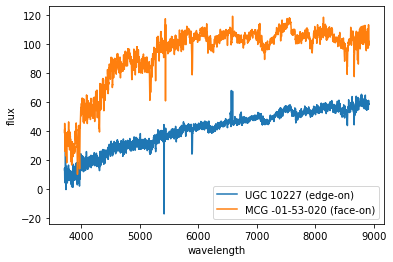

In [15]:
plt.figure()
plt.plot(10.**lam_UG, f_UG, label='UGC 10227 (edge-on)')
plt.plot(10.**lam_UG, f_MCG_interp, label='MCG -01-53-020 (face-on)')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

Now we can just divide the two arrays on the same wavelength grid to get some estimate of the extinction (here quantified in magnitude units). 

In [16]:
A = - 2.5 * np.log10(np.abs(f_UG / f_MCG_interp)) # abs() is used here to avoid invalid(negative) points

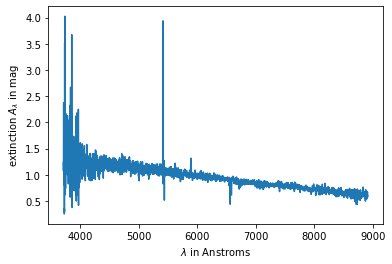

In [17]:
plt.figure()
plt.plot(10.**lam_UG, A)
plt.xlabel('$\lambda$ in Anstroms')
plt.ylabel('extinction $A_{\lambda}$ in mag')
#plt.plot(lam,lam*A)
plt.show()

Now we will estimate the total dust extinction under the assumption that the extinction follows the law:

$$\frac{A(\lambda)}{A_V} = \left(\frac {\lambda} {5500 \mathrm{~Angstrom}} \right)^{-1}$$

This is an approximation of more detailed extinction laws estimated from stellar absorption studies; e.g.  Cardelli, Clayton, and Mathis (1989).

It is important to realize that $A(\lambda)$, despite being a logarithmic measure of extinction, is multiplicatively related to $A_V$, due to the fact that the extinction is exponentially related to optical depth. It is this property that allows us to use the shape of the spectrum to determine the absolute level of extinction.

We will take a crude approach and just bracket $A_V$ with three values (0.5, 1, and 2), showing that $A_V \sim 1$ reproduces the shape of the ratio between the spectra, and that therefore $A_V \sim 1$ is about the actual level of extinction in UGC 10227.

In [18]:
AV = 1.
Amodel_10 = AV * (5500. / 10.**lam_UG)
AV = 0.5 
Amodel_05 = AV * (5500. / 10.**lam_UG)
AV = 2.0 
Amodel_20 = AV * (5500. / 10.**lam_UG)

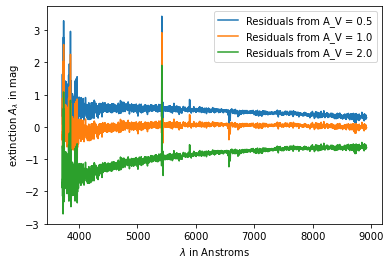

In [19]:
plt.figure()
plt.plot(10.**lam_UG, A - Amodel_05, label='Residuals from A_V = 0.5')
plt.plot(10.**lam_UG, A - Amodel_10, label='Residuals from A_V = 1.0')
plt.plot(10.**lam_UG, A - Amodel_20, label='Residuals from A_V = 2.0')
plt.xlabel('$\lambda$ in Anstroms')
plt.ylabel('extinction $A_{\lambda}$ in mag')
plt.legend()
plt.show()

Indeed, $A_V=1$ works reasonably well. The fact that the residuals are actually near zero is a coincidence related to the fact that the galaxies are approximately the same stellar mass and redshift.